In [2]:
%load_ext autoreload

In [4]:
%autoreload 2
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

from torchdrive.data import collate
from torchdrive.notebook import display_img, display_color, display, to_pil_image
from torchdrive.transforms.batch import NormalizeCarPosition

NUSCENES = True

if NUSCENES:
    from torchdrive.datasets.nuscenes_dataset import NuscenesDataset
    dataset = NuscenesDataset(
        data_dir="../../../ext3/nuscenes",
        version="v1.0-mini",
        lidar=True,
        num_frames=5,
    )
else:
    from torchdrive.datasets.rice import MultiCamDataset
    dataset = MultiCamDataset(
        index_file="../../openape/snapshots/out-mar23/index.txt",
        mask_dir="../../openape/masks",
        cameras=["main", "narrow", "fisheye", "leftpillar", "leftrepeater", "rightpillar", "rightrepeater", "backup"],
        cam_shape=(480, 640),
        nframes_per_point=5,
        limit_size=1000,
        dynamic=True,
    )
print(len(dataset))
# 120 has LIDAR alignment issues
# 500 has it fixed
example = dataset[500]
assert example is not None

#transform = NormalizeCarPosition(start_frame=0)
#batch = collate([example])
#batch = transform(batch)

#for cam in a.cameras:
#    display_img(example.color[cam][0].float())

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.476 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.
Found 2282 scenes for CAM_FRONT
Found 2342 samples for CAM_FRONT
Found 2284 scenes for CAM_FRONT_LEFT
Found 2344 samples for CAM_FRONT_LEFT
Found 2278 scenes for CAM_FRONT_RIGHT
Found 2338 samples for CAM_FRONT_RIGHT
Found 2255 scenes for CAM_BACK
Found 2315 samples for CAM_BACK
Found 2267 scenes for CAM_BACK_LEFT
Found 2327 samples for CAM_BACK_LEFT
Found 2282 scenes for CAM_BACK_RIGHT
Found 2342 samples for CAM_BACK_RIGHT
Found 3875 scenes for LIDAR_TOP
Found 3935 samples for LIDAR_TOP
2282


In [3]:
from configs.simplebev3d import CONFIG
import torch

device = torch.device('cpu')
model = CONFIG.create_model(device=device)

/home/rice/venvs/openape/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/home/rice/venvs/openape/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


load checkpoint from http path: https://dl.cv.ethz.ch/bdd100k/sem_seg/models/upernet_convnext-t_fp16_512x1024_80k_sem_seg_bdd100k.pth


/home/rice/venvs/openape/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rice/venvs/openape/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RegNet_X_800MF_Weights.IMAGENET1K_V1`. You can also use `weights=RegNet_X_800MF_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
from torch import nn
from torchdrive.transforms.batch import NormalizeCarPosition

device = torch.device('cpu')
model = CONFIG.create_model(device=device)

model.transform=NormalizeCarPosition(2)

def replace(m):
    for name, module in m.named_children():
        if isinstance(module, (
            nn.BatchNorm3d, 
            nn.BatchNorm2d, 
            nn.BatchNorm1d,
            nn.InstanceNorm2d,
            nn.InstanceNorm3d,
            nn.ReLU,
        )):
            setattr(m, name, nn.Identity())
        elif isinstance(module, nn.Conv2d):
            if module.bias is not None:
                module.bias.data.zero_()
            weight = module.weight.data
            weight.zero_()
            in_ch, out_ch, h, w = weight.shape
            ch = h // 2
            cw = w // 2
            weight[:, :, ch, cw] = 1.0/in_ch
        elif isinstance(module, nn.Conv3d):
            if module.bias is not None:
                module.bias.data.zero_()
            weight = module.weight.data
            weight.zero_()
            in_ch, out_ch, h, w, d = weight.shape
            ch = h // 2
            cw = w // 2
            cd = d // 2
            weight[:, :, ch, cw, cd] = 1.0/in_ch
        #else:
            #raise RuntimeError(f"found {module}")
            #print(module.weight.shape)
    #print(m)
model.apply(replace)

load checkpoint from http path: https://dl.cv.ethz.ch/bdd100k/sem_seg/models/upernet_convnext-t_fp16_512x1024_80k_sem_seg_bdd100k.pth


BEVTaskVan(
  (backbone): Segnet3DBackbone(
    (project): ModuleList(
      (0-2): 3 x Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
    )
    (fpn): ResnetFPN3d(
      (first_conv): Conv3d(96, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
      (bn1): Identity()
      (relu): Identity()
      (layer1): Sequential(
        (0): BasicBlock3d(
          (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (bn1): Identity()
          (relu): Identity()
          (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (bn2): Identity()
        )
        (1): BasicBlock3d(
          (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (bn1): Identity()
          (relu): Identity()
          (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (bn2): I

In [5]:
%autoreload 2
from unittest.mock import MagicMock
from torch.utils.tensorboard import SummaryWriter
import tempfile
from torchvision.transforms.functional import to_pil_image
import os


writer = MagicMock(autospec=SummaryWriter)

out = tempfile.TemporaryDirectory()

def add_image(name: str, img: object, global_step: int):
    if "CAM_FRONT/" in name or "bev" in name or "grid" in name or "dispvoxel" in name:
        print(name)
        display(to_pil_image(img))
        
def add_scalar(name: str, val: float, global_step: int):
    if False:
        print(name, val)
    
def add_scalars(name: str, val: float, global_step: int):
    if 'grid' in name:
        print(name, val)
    
writer.add_image.side_effect = add_image
writer.add_scalar.side_effect = add_scalar
writer.add_scalars.side_effect = add_scalars

batch = collate([example]).to(device)
for cam in batch.color:
    batch.color[cam] = torch.full_like(batch.color[cam], fill_value=-1)
    
batch.color["CAM_FRONT"][:, 2, :, 280:320, 540:580] = 100.0
#print(batch.color["CAM_FRONT"].shape)

model(batch=batch, global_step=1000, writer=writer, output=out.name)

RuntimeError: expected scalar type BFloat16 but found Float

In [105]:
T = model.backbone.volume_locator.get_local_to_world_coords_transform().get_matrix().permute(0, 2, 1)
zero = torch.tensor((0,0,0,1.0), device=device)
T.matmul(zero)

tensor([[0.0000, 0.0000, 2.1333, 1.0000]], device='cuda:0')

In [109]:
batch.world_to_cam("CAM_FRONT", 2).matmul(zero)

tensor([[-1.6480e+03,  7.1756e-01,  3.0752e+02,  9.9998e-01]], device='cuda:0')

In [5]:
import torch
from torchdrive.transforms.img import render_color

img = torch.zeros(2,3, device=torch.device('cuda'))
render_color(img)

tensor([[[0.0015, 0.0015, 0.0015],
         [0.0015, 0.0015, 0.0015]],

        [[0.0005, 0.0005, 0.0005],
         [0.0005, 0.0005, 0.0005]],

        [[0.0139, 0.0139, 0.0139],
         [0.0139, 0.0139, 0.0139]]], dtype=torch.float64)

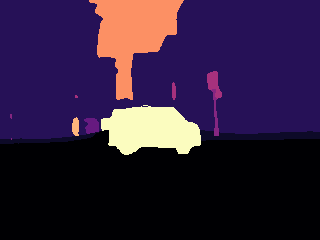

In [17]:
import safetensors.torch
import zstd

path = "/mnt/ext3/autolabel/nuscenes/sem_seg/00889f8a9549450aa2f32cf310a3e305.safetensors.zstd"
with open(path, "rb") as f:
    decomp = zstd.ZSTD_uncompress(f.read())
out = safetensors.torch.load(decomp)
front = out['CAM_FRONT'].bfloat16()/255
display_color(front.argmax(dim=0))